# Understanding errors in kalman gains

## Preliminaries

### Load packages

In [1]:
import numpy as np
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd

In [2]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [3]:
from post_processing_fns import *
from letkf import *

In [4]:
which_columns2 = {
  'lons' : [-154.5, 35.5, 75.5, -150.5, 160.5],
  'lats' : [-27.5, -49.5, -31.5, 12.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific2', 'southern_ocean2', 'indian_ocean2', 'tropical_pacific2', 'north_pacific']
}

In [5]:
these_columns = which_columns2

In [6]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots/five_columns_error_in_kalman_gain/'
my_data_dir = proj_dir + '/my_data/20151206.030000'
nb_dir = proj_dir + '/notebooks'

### Load data

In [7]:
## Load vertical columns
south_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][0]+'.nc')
southern_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][1]+'.nc')
indian_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][2]+'.nc')
tropical_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][3]+'.nc')
north_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][4]+'.nc')

In [8]:
# Load covariance matrices
sp_cov = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cov.npy')
so_cov = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cov.npy')
io_cov = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cov.npy')
tp_cov = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cov.npy')
np_cov = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cov.npy')

In [9]:
# Load correlation matrices
sp_cor = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cor.npy')
so_cor = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cor.npy')
io_cor = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cor.npy')
tp_cor = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cor.npy')
np_cor = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cor.npy')

### Process data

In [10]:
# Compute atm pressure from pressure thickness of each level
south_pacific['atm_p'] = south_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
southern_ocean['atm_p'] = southern_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
indian_ocean['atm_p'] = indian_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
tropical_pacific['atm_p'] = tropical_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
north_pacific['atm_p'] = north_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2

In [11]:
## Get indices of relevant pressure levels in atm and depth levels in ocn
# atmosphere
num_atm_levs = len(south_pacific['atm_lev'])
ind_ast = num_atm_levs - 1
ind100hPa = np.argmin(np.abs(south_pacific['atm_p'].mean(['lat', 'lon']).values-100))
ind800hPa = np.argmin(np.abs(south_pacific['atm_p'].mean(['lat', 'lon']).values-800))
# ocean
ind0m = num_atm_levs
ind_sst = ind0m
ind150m_ocn = np.argmin(np.abs(south_pacific['ocn_lev'].values-150))
ind2km_ocn  = np.argmin(np.abs(south_pacific['ocn_lev'].values-2000))
num_ocn_levs = len(south_pacific['ocn_lev'])
# both
ind150m = ind0m + ind150m_ocn
ind2km = ind0m + ind2km_ocn
num_tot_levs = num_atm_levs + num_ocn_levs

In [12]:
def get_column_mean(ds):
    # initialize array
    num_atm_levs = len(ds['atm_lev'])
    num_ocn_levs = len(ds['ocn_lev'])
    num_tot_levs = num_atm_levs + num_ocn_levs
    ds_manual = np.empty(num_tot_levs)
    # Get mean of atm bootstrapped ensemble
    ds_atm = ds['atm_T'].mean(['lat', 'lon', 'ens_mem'])
    ds_atm = ds_atm.to_numpy()
    # Get mean of ocn bootstrapped ensemble
    ds_ocn = ds['ocn_Temp'].mean(['lat', 'lon', 'ens_mem'])
    ds_ocn = ds_ocn.to_numpy()
    # Store atm and ocn temperature mean
    ds_manual[:num_atm_levs] = ds_atm - 273.15
    ds_manual[num_atm_levs:num_tot_levs] = ds_ocn
    ds_manual = np.atleast_2d(ds_manual).transpose()
    return ds_manual

In [13]:
# Get mean temperature profiles
sp_avg = get_column_mean(south_pacific)
so_avg = get_column_mean(southern_ocean)
io_avg = get_column_mean(indian_ocean)
tp_avg = get_column_mean(tropical_pacific)
np_avg = get_column_mean(north_pacific)

### Define parameters

In [14]:
# Define a range of localization radii for ocn and atm
loc_rads_ocn = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220]
loc_rads_atm = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
loc_rads_crs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
loc_rad_noloc = 1e5

In [15]:
## Set inputs for assimilation of ast into atm

# Which column?
ds = indian_ocean#southern_ocean#south_pacific#north_pacific#tropical_pacific
this_avg = io_avg#so_avg#sp_avg#np_avg#tp_avg
this_cov = io_cov#so_cov#sp_cov#np_cov#tp_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
fullname = 'Indian Ocean'#'Southern Ocean'#'South Pacific'#'North Pacific'#'Tropical Pacific'
shortname = 'io'#'so'#'sp'#'np'#'tp' 

# Which indices correspond to the state? the observation?
#ind_state = np.arange(ind100hPa, num_atm_levs)
ind_state = np.arange(ind0m, ind2km)
ind_ob = ind_ast
#ind_ob = ind_sst
prefix = 'ast_into_ocn'#'sst_into_ocn'#'sst_into_atm'
full_prefix = 'AST into OCN'#'SST into OCN' #'SST into ATM'

# Which positions correspond to the state? the observation?
#atm_p = ds['atm_p'].mean(['lat', 'lon']).to_numpy()
#pos_state = np.abs(np.log(atm_p) - np.log(atm_p[-1]))
#pos_ob = pos_state[-1]
ocn_z = ds['ocn_lev'].to_numpy()
pos_state = ocn_z - ocn_z[0]
pos_ob = pos_state[0]

In [40]:
atm_p = ds['atm_p'].mean(['lat', 'lon']).to_numpy()

In [41]:
pos_state = np.abs(np.log(atm_p) - np.log(atm_p[-1]))

In [52]:
loc_rads_atm

[0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]

In [51]:
np.exp(np.log(atm_p[-1])-loc_rads_atm)

array([833.95099418, 682.78132549, 559.01406881, 457.68200954,
       374.71833634, 306.7934257 , 251.18121247, 205.64978324,
       168.3718019 , 137.85117217, 112.862994  ])

In [50]:
atm_p[-1] - np.exp(np.log(atm_p[-1])-loc_rads_atm)

array([184.63921578, 335.80888447, 459.57614115, 560.90820042,
       643.87187362, 711.79678426, 767.4089975 , 812.94042672,
       850.21840806, 880.73903779, 905.72721596])

### Plot Kalman gains for each column

In [16]:
def get_perfect_kalman_gain(this_cov, ind_state, ind_ob):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1

    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()

    ## Get perfect kalman gain
    perfect_kg = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    perfect_kg = perfect_kg[ind_state, 0]
    
    return perfect_kg

In [17]:
sp_kg = get_perfect_kalman_gain(sp_cov, ind_state, ind_ob)
so_kg = get_perfect_kalman_gain(so_cov, ind_state, ind_ob)
io_kg = get_perfect_kalman_gain(io_cov, ind_state, ind_ob)
tp_kg = get_perfect_kalman_gain(tp_cov, ind_state, ind_ob)
np_kg = get_perfect_kalman_gain(np_cov, ind_state, ind_ob)

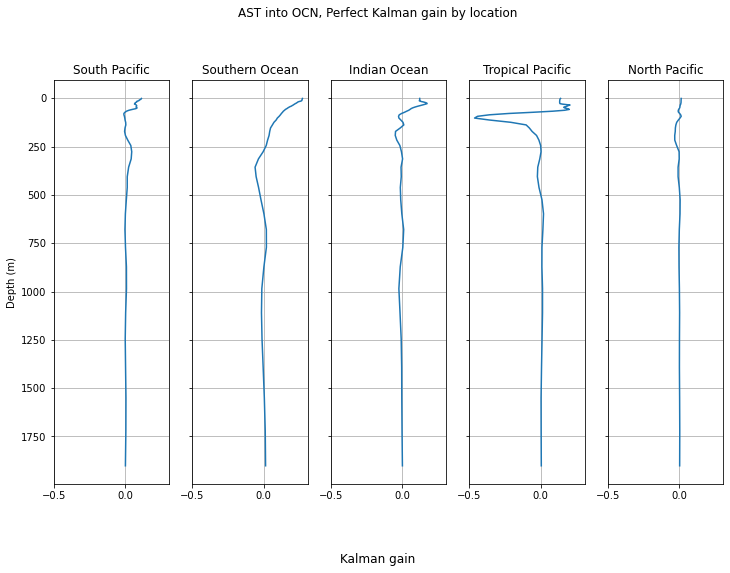

In [37]:
## Create subplots
fig, axs = plt.subplots(ncols=5, sharey=True, sharex=True) 

# Plot atm temperature

#axs[0].plot(sp_kg, south_pacific['atm_p'].mean(['lat', 'lon']).to_numpy()[ind100hPa:])
#axs[1].plot(so_kg, southern_ocean['atm_p'].mean(['lat', 'lon']).to_numpy()[ind100hPa:])
#axs[2].plot(io_kg, indian_ocean['atm_p'].mean(['lat', 'lon']).to_numpy()[ind100hPa:])
#axs[3].plot(tp_kg, tropical_pacific['atm_p'].mean(['lat', 'lon']).to_numpy()[ind100hPa:])
#axs[4].plot(np_kg, north_pacific['atm_p'].mean(['lat', 'lon']).to_numpy()[ind100hPa:])

axs[0].plot(sp_kg, ocn_z[:ind2km_ocn])
axs[1].plot(so_kg, ocn_z[:ind2km_ocn])
axs[2].plot(io_kg, ocn_z[:ind2km_ocn])
axs[3].plot(tp_kg, ocn_z[:ind2km_ocn])
axs[4].plot(np_kg, ocn_z[:ind2km_ocn])

# Set titles
axs[0].set_title('South Pacific')
axs[1].set_title('Southern Ocean')
axs[2].set_title('Indian Ocean')
axs[3].set_title('Tropical Pacific')
axs[4].set_title('North Pacific')

# Adjust and label axes
#axs[0].set_yscale('log')
plt.gca().invert_yaxis()
#axs[0].set_ylabel('Atmospheric pressure (hPa)')
axs[0].set_ylabel('Depth (m)')
fig.supxlabel('Kalman gain')
fig.suptitle(full_prefix+', Perfect Kalman gain by location')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(3.5)
    

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/'+prefix+'_'+'perfect_kalman_gain_five_columns')
plt.show()

## Assimilate AST/SST into ATM/OCN

### Plot metric for different localization radii with EnKF and LETKF

In [19]:
def create_distance_matrix(spatial_locations):
    N = len(spatial_locations) 
    # Create distance matrix
    dis = np.zeros((N,N))
    for jj in range(N):
        for ii in range(N):
            d = np.abs(spatial_locations[ii]-spatial_locations[jj])
            dis[ii, jj] = d
    return dis

In [20]:
def compute_relative_error(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, use_loc=True, ind_top_of_fluid=0):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1
    
    ## Generate synthetic observations
    xt = this_avg + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1)) 
    y_ob = HofX @ ( xt + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1))) # obs error set to equal 'perfect' background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = this_cov_sqrt @ rnd
    P_ens = np.cov(x_err_ens)
    x_ens = this_avg + x_err_ens

    ## Form background observation perturbations
    y_ens = HofX @ x_ens
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    R_inv = np.reciprocal(R)
    
    ## Calculate background mean and innovation
    background_mean = np.mean(x_ens, 1)
    innovation = y_ob - HofX @ background_mean
    
    ## Compute perfect analysis
    perfect_kg = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    
    ## Precompute some terms for EnKF -- assumes point observation & single domain OR observation at the interface
    HPHT = HofX @ P_ens @ HofX.transpose()
    PHT = P_ens @ HofX.transpose()
    dist = np.abs(pos_state - pos_ob)
    
    ## Take only state
    x_ens = x_ens[ind_state]
    background_mean = background_mean[ind_state]
    perfect_kg = perfect_kg[ind_state, 0]
    pos_state = pos_state[(ind_state - ind_top_of_fluid)]
    PHT = PHT[ind_state,0]
    dist = dist[(ind_state-ind_top_of_fluid)]
    
    ## Get relative error for each localization radius
    num_loc_rads =  len(loc_rads_state)
    norm_rel_error_enkf = np.empty(num_loc_rads)
    norm_rel_error_letkf = np.empty(num_loc_rads)
    for loc_ind in range(num_loc_rads):
        # Get localization radius
        localization_radius = loc_rads_state[loc_ind]
        # EnKF update
        if use_loc:
            loc = gaspari_cohn(dist/(localization_radius/2))
            CHT = loc * PHT # Localize ensemble covariance (inefficient, but OK for a small system)
        else:
            CHT = PHT
        enkf_kg = (( CHT )/( HPHT[0,0] + R[0,0] )).squeeze() # Bad! But OK for single ob (scalar R)
        # LETKF update
        loc_rad_state = np.full_like(pos_state, localization_radius)
        analysis_mean_letkf = letkf(x_ens, y_ens, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1, use_loc=use_loc)[0]
        letkf_kg = (analysis_mean_letkf - background_mean)/innovation
        # Compute relative error
        kg_err_enkf = perfect_kg - enkf_kg
        kg_err_letkf = perfect_kg - letkf_kg
        # Store relative error
        norm_rel_error_enkf[loc_ind] = np.sqrt(np.sum(np.square(kg_err_enkf))) / np.sqrt(np.sum(np.square(perfect_kg)))
        norm_rel_error_letkf[loc_ind] = np.sqrt(np.sum(np.square(kg_err_letkf))) / np.sqrt(np.sum(np.square(perfect_kg)))
    
    return norm_rel_error_enkf, norm_rel_error_letkf

In [21]:
def run_multiple_trials_rel_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, num_trials=100, use_loc=True, ind_top_of_fluid=0):
    norm_rel_errors_enkf = np.empty((len(loc_rads_state), num_trials))
    norm_rel_errors_letkf = np.empty((len(loc_rads_state), num_trials))
    for trial in range(num_trials):
        norm_rerr_enkf, norm_rerr_letkf = compute_relative_error(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc, ind_top_of_fluid=ind_top_of_fluid)
        norm_rel_errors_enkf[:, trial] = norm_rerr_enkf
        norm_rel_errors_letkf[:, trial] = norm_rerr_letkf
    return norm_rel_errors_enkf, norm_rel_errors_letkf

In [22]:
# Set localization inputs for assimilation of ast into atm
loc_rads_state = loc_rads_ocn#loc_rads_crs#loc_rads_atm
loc_rad_ob = loc_rad_noloc
use_loc = True
ind_top_of_fluid = ind0m

In [23]:
norm_rel_errors_enkf, norm_rel_errors_letkf = run_multiple_trials_rel_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=use_loc, ind_top_of_fluid=ind_top_of_fluid)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


In [24]:
norm_rel_errors_enkf_noloc, norm_rel_errors_letkf_noloc = run_multiple_trials_rel_err(ind_state, ind_ob, [loc_rad_noloc], loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=False, ind_top_of_fluid=ind_top_of_fluid)

In [25]:
# Get errors with localization 
for ii in range(norm_rel_errors_enkf.shape[0]):
    data_enkf = {'error': norm_rel_errors_enkf[ii,:], 
                 'loc_rad': loc_rads_state[ii],
                 'da_method': 'EnKF',
                 'localization': True}
    data_letkf = {'error': norm_rel_errors_letkf[ii,:], 
                  'loc_rad': loc_rads_state[ii],
                  'da_method': 'LETKF',
                  'localization': True}
    df_enkf_hold = pd.DataFrame(data_enkf)
    df_letkf_hold = pd.DataFrame(data_letkf)
    if ii == 0:
        df_manual = pd.concat([df_enkf_hold, df_letkf_hold])
    else:
        df_manual = pd.concat([df_manual, df_enkf_hold, df_letkf_hold])
# Get errors without localization
data_enkf = {'error': norm_rel_errors_enkf_noloc[0,:], 
             'loc_rad': np.Inf,
             'da_method': 'EnKF',
             'localization': False}
data_letkf = {'error': norm_rel_errors_letkf_noloc[0,:], 
              'loc_rad': np.Inf,
              'da_method': 'LETKF',
              'localization': False}
df_enkf_hold = pd.DataFrame(data_enkf)
df_letkf_hold = pd.DataFrame(data_letkf)
df_manual = pd.concat([df_manual, df_enkf_hold, df_letkf_hold])

In [26]:
def convert_to_dataarray(loc_rads_state, norm_rel_errors_enkf, norm_rel_errors_letkf, norm_rel_errors_enkf_noloc, norm_rel_errors_letkf_noloc):
    da_enkf = xr.DataArray( data=norm_rel_errors_enkf.T, dims=["trial", "loc_rad"], 
                           coords=dict(trial=np.arange(norm_rel_errors_enkf.shape[1]),loc_rad=loc_rads_state,da_method='EnKF'))
    da_letkf = xr.DataArray( data=norm_rel_errors_letkf.T, dims=["trial", "loc_rad"], 
                           coords=dict(trial=np.arange(norm_rel_errors_enkf.shape[1]),loc_rad=loc_rads_state,da_method='LETKF'))
    da_enkf_noloc = xr.DataArray( data=norm_rel_errors_enkf_noloc[0,:], dims=["trial"], 
                           coords=dict(trial=np.arange(norm_rel_errors_enkf_noloc.shape[1]), loc_rad=np.NAN, da_method='EnKF-NoLoc'))
    da_letkf_noloc = xr.DataArray( data=norm_rel_errors_letkf_noloc[0,:], dims=["trial"], 
                           coords=dict(trial=np.arange(norm_rel_errors_letkf_noloc.shape[1]), loc_rad=np.NAN, da_method='LETKF-NoLoc'))
    da = xr.concat([da_enkf, da_letkf], dim='da_method')
    da_noloc = xr.concat([da_enkf_noloc, da_letkf_noloc], dim='da_method')
    return da, da_noloc

In [27]:
da, da_noloc = convert_to_dataarray(loc_rads_state, norm_rel_errors_enkf, norm_rel_errors_letkf, norm_rel_errors_enkf_noloc, norm_rel_errors_letkf_noloc)

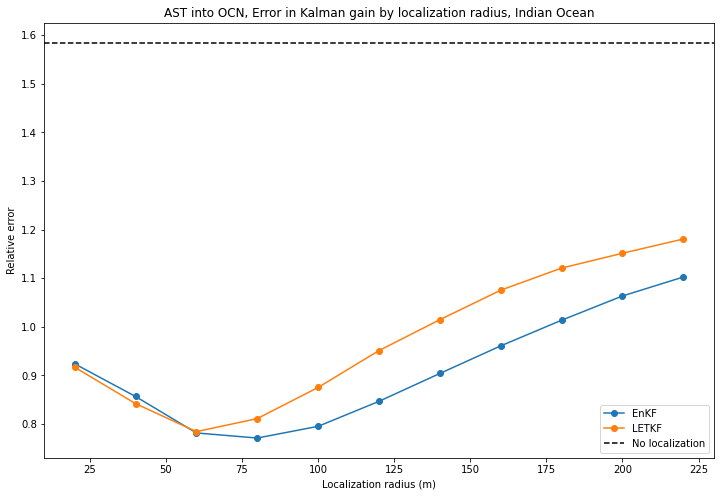

In [28]:
plt.plot(da['loc_rad'], da.sel(da_method='EnKF').median('trial'), '-o', label='EnKF')
plt.plot(da['loc_rad'], da.sel(da_method='LETKF').median('trial'), '-o', label='LETKF')
plt.axhline(y=da_noloc.median(), color='k', linestyle='--', label='No localization')
plt.legend()

# Adjust and label axes
plt.title(full_prefix+', Error in Kalman gain by localization radius, '+fullname)
plt.ylabel('Relative error')
#plt.xlabel('Localization radius (log pressure)')
plt.xlabel('Localization radius (m)')

# Adjust aesthetics
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
plt.savefig(plot_dir+'/'+prefix+'_'+shortname+'_relative_error_by_loc_rad')
plt.show()

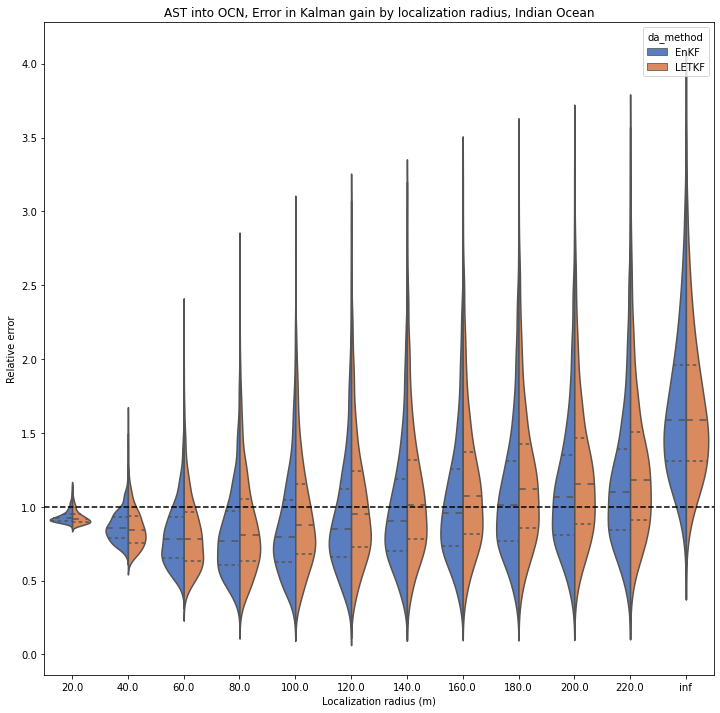

In [29]:
sns.violinplot(data=df_manual, x='loc_rad', y='error', hue='da_method', split=True, inner='quartiles', palette="muted")
plt.axhline(y=1, color='k', linestyle='--', label='Assim worse than no assim')


# Adjust and label axes
plt.title(full_prefix+', Error in Kalman gain by localization radius, '+fullname)
plt.ylabel('Relative error')
#plt.xlabel('Localization radius (log pressure)')
plt.xlabel('Localization radius (m)')

# Adjust aesthetics
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
plt.savefig(plot_dir+'/'+prefix+'_'+shortname+'_relative_error_by_loc_rad_violin')
plt.show()

### Plot increments with different ensemble sizes

In [30]:
# Set ensemble sizes and localization inputs for assimilation of ast into atm
ens_sizes = [2, 4, 8, 16, 32, 64, 128, 256]
loc_rads_state = loc_rads_ocn#[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]#[0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
loc_rad_ob = loc_rad_noloc
use_loc = True

In [31]:
def run_multiple_trials_norm_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_sizes, num_trials=100, use_loc=True, ind_top_of_fluid=0):
    norm_rel_errors_enkf = np.empty((len(ens_sizes), len(loc_rads_state), num_trials))
    norm_rel_errors_letkf = np.empty((len(ens_sizes), len(loc_rads_state), num_trials))
    for ens_ind in range(len(ens_sizes)):
        ens_size = ens_sizes[ens_ind]
        for trial in range(num_trials):
            norm_rerr_enkf, norm_rerr_letkf = compute_relative_error(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc, ind_top_of_fluid=ind_top_of_fluid)
            norm_rel_errors_enkf[ens_ind, :, trial] = norm_rerr_enkf
            norm_rel_errors_letkf[ens_ind, :, trial] = norm_rerr_letkf
    return norm_rel_errors_enkf, norm_rel_errors_letkf

In [32]:
norm_rel_errors_enkf, norm_rel_errors_letkf = run_multiple_trials_norm_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_sizes, num_trials=100, use_loc=use_loc, ind_top_of_fluid=ind_top_of_fluid)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)
/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:44: RuntimeWarning: invalid value encountered in reciprocal
  gc[less2] = 1/12*dist[less2]**5 - .5*dist[less2]**4 + 0.625*dist[less2]**3 + 5/3*dist[less2]**2 - 5*dist[less2] + 4 - 2/3*dist[less2]**-1 ;


In [33]:
norm_rel_errors_enkf_noloc, norm_rel_errors_letkf_noloc = run_multiple_trials_norm_err(ind_state, ind_ob, [loc_rad_noloc], loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_sizes, num_trials=100, use_loc=False, ind_top_of_fluid=ind_top_of_fluid)

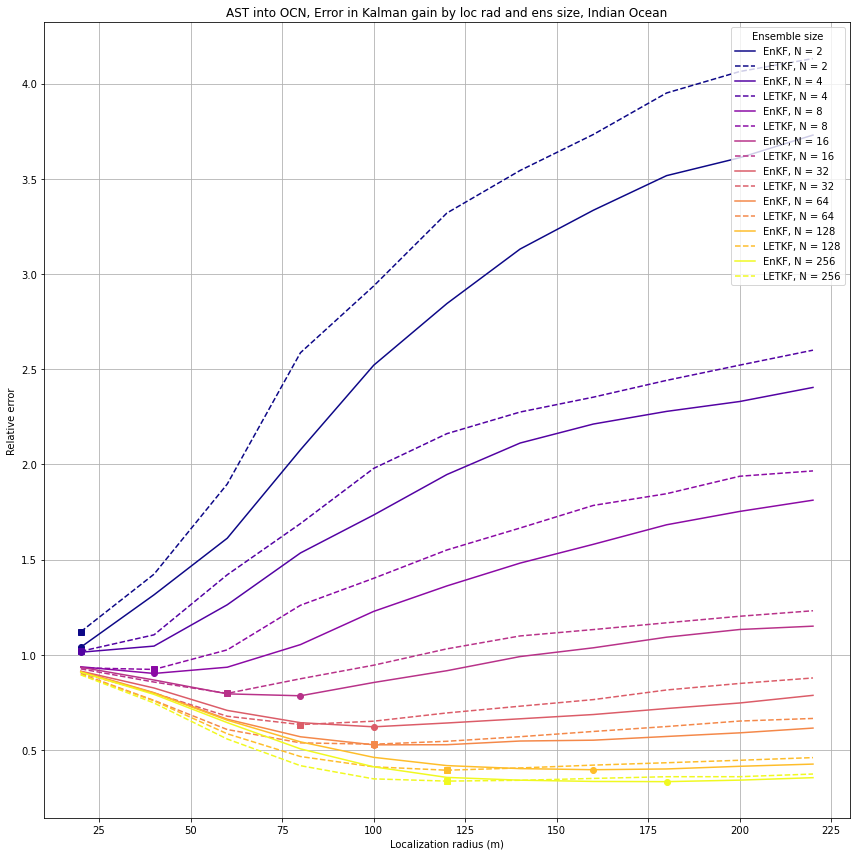

In [34]:
## Create subplots
fig, axs = plt.subplots(ncols=1, nrows=1) 

## Process data
data_enkf = np.median(norm_rel_errors_enkf, axis=2)
data_letkf = np.median(norm_rel_errors_letkf, axis=2)
n = data_enkf.shape[0]
colors = plt.cm.plasma(np.linspace(0,1,n))

# Plot data
for i in range(n):
    axs.plot(loc_rads_state, data_enkf[i,:], color=colors[i], label='EnKF, N = '+str(ens_sizes[i]))
    axs.plot(loc_rads_state, data_letkf[i,:], '--', color=colors[i], label='LETKF, N = '+str(ens_sizes[i]))
    min_ind_enkf = np.argmin(data_enkf[i,:])
    min_ind_letkf = np.argmin(data_letkf[i,:])
    axs.plot(loc_rads_state[min_ind_enkf], data_enkf[i, min_ind_enkf], 'o', color=colors[i])
    axs.plot(loc_rads_state[min_ind_letkf], data_letkf[i, min_ind_letkf], 's', color=colors[i])

# Legend
axs.legend(title='Ensemble size', loc='upper right')
    
# Labels
#axs.set_xlabel('Localization radius (log pressure)')
axs.set_xlabel('Localization radius (m)')
axs.set_ylabel('Relative error')
axs.set_title(full_prefix+', Error in Kalman gain by loc rad and ens size, '+fullname)

# Add/remove grid lines
axs.grid()


# Save and show
plt.tight_layout()
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/'+prefix+'_'+shortname+'_err_vs_loc_rad_and_ens_size')
plt.show()

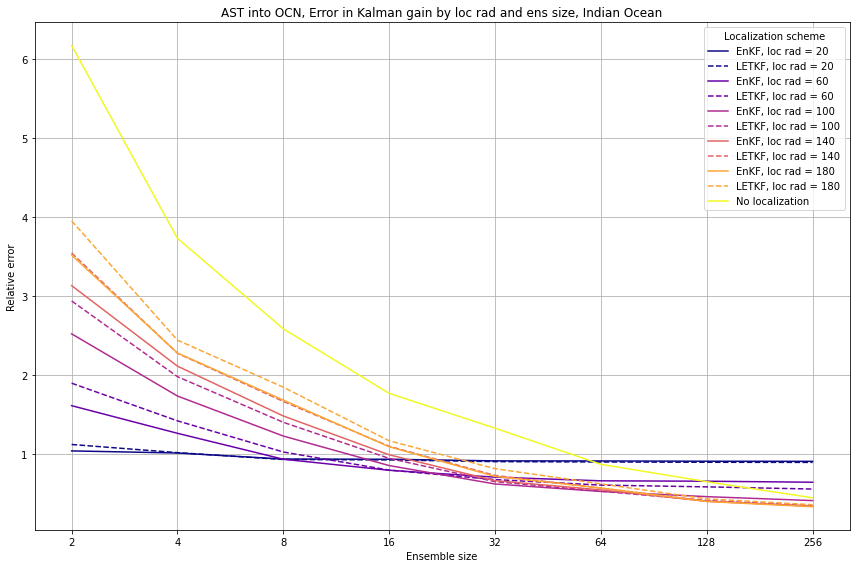

In [35]:
## Create subplots
fig, axs = plt.subplots(ncols=1, nrows=1) 

## Process data
data_enkf = np.median(norm_rel_errors_enkf, axis=2)
data_letkf = np.median(norm_rel_errors_letkf, axis=2)
data_enkf_noloc = np.median(norm_rel_errors_enkf_noloc[:,0,:], axis=1)
data_letkf_noloc = np.median(norm_rel_errors_letkf_noloc[:,0,:], axis=1)
n = data_enkf.shape[1]
colors = plt.cm.plasma(np.linspace(0,1,n))

# Plot data
for i in range(n//2):
    axs.plot(ens_sizes, data_enkf[:,2*i], color=colors[2*i], label='EnKF, loc rad = '+str(loc_rads_state[2*i]))
    axs.plot(ens_sizes, data_letkf[:,2*i], '--', color=colors[2*i], label='LETKF, loc rad = '+str(loc_rads_state[2*i]))
    
axs.plot(ens_sizes, data_letkf_noloc, color=colors[-1], label='No localization')

# Legend
axs.legend(title='Localization scheme', loc='upper right')
    
# Labels
axs.set_xlabel('Ensemble size')
axs.set_ylabel('Relative error')
axs.set_title(full_prefix+', Error in Kalman gain by loc rad and ens size, '+fullname)

# Add/remove grid lines
axs.grid()
axs.set_xscale('log', base=2)
axs.set_xticks(ens_sizes)
axs.get_xaxis().set_major_formatter(ticker.ScalarFormatter())


# Save and show
plt.tight_layout()
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/'+prefix+'_'+shortname+'_err_vs_ens_size')
plt.show()

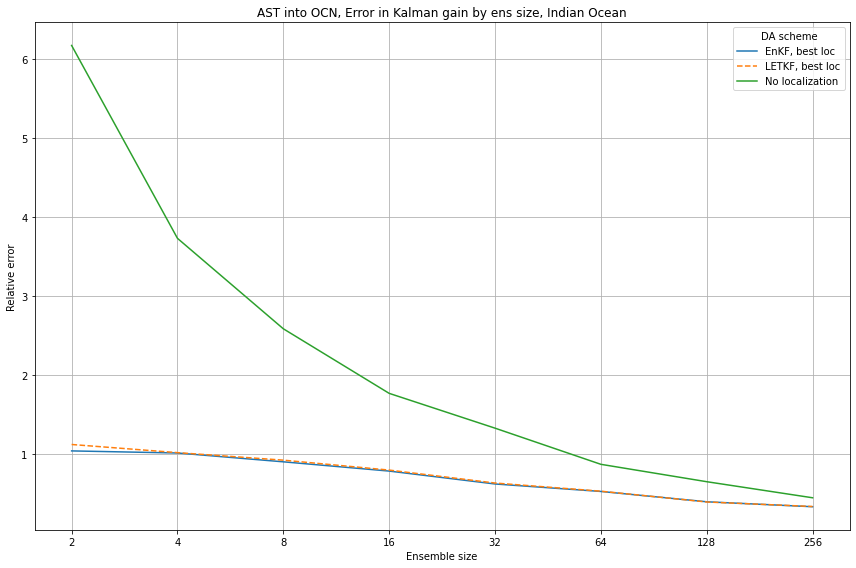

In [36]:
## Create subplots
fig, axs = plt.subplots(ncols=1, nrows=1) 

## Process data
n = data_enkf.shape[0]
data_enkf_bestloc = np.zeros(n)
data_letkf_bestloc = np.zeros(n)
for ind in range(n):
    data_enkf_bestloc[ind] = np.min(data_enkf[ind,:])
    data_letkf_bestloc[ind] = np.min(data_letkf[ind,:])

# Plot data
axs.plot(ens_sizes, data_enkf_bestloc, label='EnKF, best loc')
axs.plot(ens_sizes, data_letkf_bestloc, '--', label='LETKF, best loc')
axs.plot(ens_sizes, data_letkf_noloc, label='No localization')

# Legend
axs.legend(title='DA scheme', loc='upper right')
    
# Labels
axs.set_xlabel('Ensemble size')
axs.set_ylabel('Relative error')
axs.set_title(full_prefix+', Error in Kalman gain by ens size, '+fullname)

# Add/remove grid lines
axs.grid()
axs.set_xscale('log', base=2)
axs.set_xticks(ens_sizes)
axs.get_xaxis().set_major_formatter(ticker.ScalarFormatter())


# Save and show
plt.tight_layout()
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/'+prefix+'_'+shortname+'_err_vs_ens_size_bestloc')
plt.show()